In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
import matplotlib.pyplot as plt
from packages.utils import plot_kfold


# Dataset import and cleaning

In [23]:
#  df = pd.read_csv('data/Auto.csv')
df = pd.read_csv('https://github.com/vincenzorrei/EDU-Datasets/raw/refs/heads/main/Auto.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


The horsepower column is currently of type object, indicating that its data contains non-numeric values (e.g., strings or possibly missing/invalid entries). Since horsepower represents a numerical feature, it should ideally be converted to a numeric data type (float or int) for meaningful analysis or modeling.


In [24]:
# Converts the column values to numeric, replacing those that cannot be converted with NaN.
nan_index = pd.to_numeric(df['horsepower'], errors='coerce').isna()

# Get the non-numeric values
non_numeric_values = df['horsepower'][nan_index]
print(non_numeric_values.value_counts())

horsepower
?    5
Name: count, dtype: int64


The presence of the value ? in your horsepower column is likely due to one of the following reasons:

- Data Entry Issues:
In the source data, ? might have been used as a placeholder for missing or unknown values instead of leaving the field blank or using a standard missing value indicator like NaN.

- Formatting in the Dataset:
If the data was extracted from a text file (e.g., CSV, TSV), ? might have been used as a way to indicate incomplete or invalid entries.

- Original Dataset Conventions:
In some older datasets, especially in UCI repositories or similar, ? is commonly used to signify "unknown" or "not applicable."

In [25]:
# Replace problematic values like '?' with NaN
df['horsepower'] = df['horsepower'].replace('?', np.nan)

# Convert 'horsepower' to numeric (non-numeric values become NaN)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows where 'horsepower' is NaN
df.dropna(subset=['horsepower'], inplace=True)

print(df.isna().sum())


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


In [26]:
# Create polynomial features
max_polynomial_degree = 10

for i in range(2, max_polynomial_degree+1):
    df[f'horsepower^{i}'] = df['horsepower'] ** i


## Select X and y

In [27]:
# Store the column names of the horsepower columns
horsepower_cols = [i for i in df.columns if 'horsepower' in i]

# Split the data into X and y
X = df[horsepower_cols]
y = df['mpg']

X.head()

,horsepower,horsepower^2,horsepower^3,horsepower^4,horsepower^5,horsepower^6,horsepower^7,horsepower^8,horsepower^9,horsepower^10
0,130.0,16900.0,2197000.0,285610000.0,3.712930e+10,4.826809e+12,6.274852e+14,8.157307e+16,1.060450e+19,1.378585e+21
1,165.0,27225.0,4492125.0,741200625.0,1.222981e+11,2.017919e+13,3.329566e+15,5.493784e+17,9.064743e+19,1.495683e+22
2,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
3,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
4,140.0,19600.0,2744000.0,384160000.0,5.378240e+10,7.529536e+12,1.054135e+15,1.475789e+17,2.066105e+19,2.892547e+21


# Train & Test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 1. Validation Set Approach

The validation approach in data science and machine learning is a method for assessing the performance of a model on unseen data.

Its primary purpose is to ensure that the model generalizes well to new, unseen datasets. This approach involves splitting the available data into different sets (usually 50% vs- 50%) and evaluating the model using these subsets

In [29]:
# Dividing the dataset into training and val sets using cross-validation
prop = 0.5
X_train_cross, X_val, y_train_cross, y_val = train_test_split(X_train, y_train, test_size=prop, random_state=2)


In [30]:
# Choose the model
regr = LinearRegression()
results = {}

# Create a loop
for i in range(1, len(horsepower_cols)+1):

    # Fit the model
    regr.fit(X_train_cross[horsepower_cols[:i]], y_train_cross)

    # Predict the target variable
    y_val_pred = regr.predict(X_val[horsepower_cols[:i]])
    
    # Calculate the MSE
    mse = mean_squared_error(y_val, y_val_pred)
    results[horsepower_cols[i-1]] = mse
    print(f'MSE for polynomial degree {i}: {mse:.4f}')


# Convert results to DataFrame for plotting
results_val = pd.DataFrame([results])

MSE for polynomial degree 1: 22.6642
MSE for polynomial degree 2: 15.3694
MSE for polynomial degree 3: 15.9084
MSE for polynomial degree 4: 16.2184
MSE for polynomial degree 5: 16.1065
MSE for polynomial degree 6: 16.1730
MSE for polynomial degree 7: 16.0399
MSE for polynomial degree 8: 15.8621
MSE for polynomial degree 9: 15.6638
MSE for polynomial degree 10: 15.7123


In [31]:
color_blue = "#1a559e"
color_blue_vivid = "#0070c0"
color_blue_light = "dodgerblue"
color_pink = "#e71d71"
color_black = "black"
color_gold = "#FFD700"
color_orange = "orange"
color_red = "darkred"


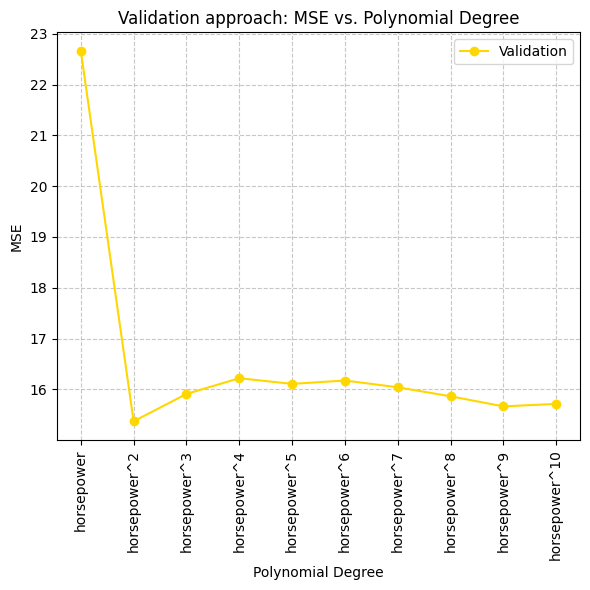

In [32]:
# Plot the results
figsize = (6,6)
plt.figure(figsize=figsize)
plt.plot(results_val.T, marker='o', label='Validation', color=color_gold)
plt.xlabel('Polynomial Degree')
plt.xticks(ticks=range(len(results_val.columns)), labels=results_val.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Validation approach: MSE vs. Polynomial Degree')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# 2. K-Fold Cross Validation


The choice of the optimal number of 
𝑘
k in k-fold cross-validation is a trade-off between the accuracy of the model performance estimate and computational cost. Typically, a 
𝑘
k between 5 and 10 is used

In [33]:
# Initialize the linear regression model
regr = LinearRegression()

# Create the K-Fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the scorer for Mean Squared Error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    regr, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 19.353424621464832


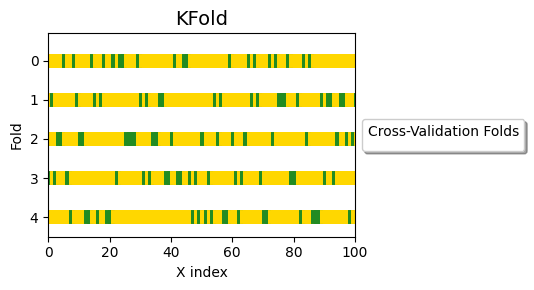

In [34]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
# Define custom colors for the plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Custom color palette

# Plot with custom colors and legend
plot_kfold(cv, X_train, y_train, ax, 5) # reduced to make the plot readable

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), 
          title='Cross-Validation Folds', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
fig.subplots_adjust(right=0.6)

In [35]:
# Initialize dictionary to store results
cv_results_KF = {}

# Create the K-Fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each polynomial degree
for i in range(1, len(horsepower_cols)+1):
    # Perform cross-validation
    scores = cross_val_score(
        regr, X_train[horsepower_cols[:i]], y_train, 
        cv=cv, scoring=mse_scorer, n_jobs=-1
    )
    # Calculate the mean of the MSE scores (negate to get actual MSE)
    mean_mse = -scores.mean()
    # Store in results dictionary
    cv_results_KF[horsepower_cols[i-1]] = mean_mse

    print(f'Mean CV MSE for {horsepower_cols[i-1]}: {mean_mse:.4f}')

# Convert results to DataFrame for plotting
cv_results_KF = pd.DataFrame([cv_results_KF])


Mean CV MSE for horsepower: 24.9531
Mean CV MSE for horsepower^2: 19.2762
Mean CV MSE for horsepower^3: 19.2797
Mean CV MSE for horsepower^4: 19.3815
Mean CV MSE for horsepower^5: 19.0807
Mean CV MSE for horsepower^6: 19.2134
Mean CV MSE for horsepower^7: 19.1471
Mean CV MSE for horsepower^8: 19.1857
Mean CV MSE for horsepower^9: 19.1910
Mean CV MSE for horsepower^10: 19.3534


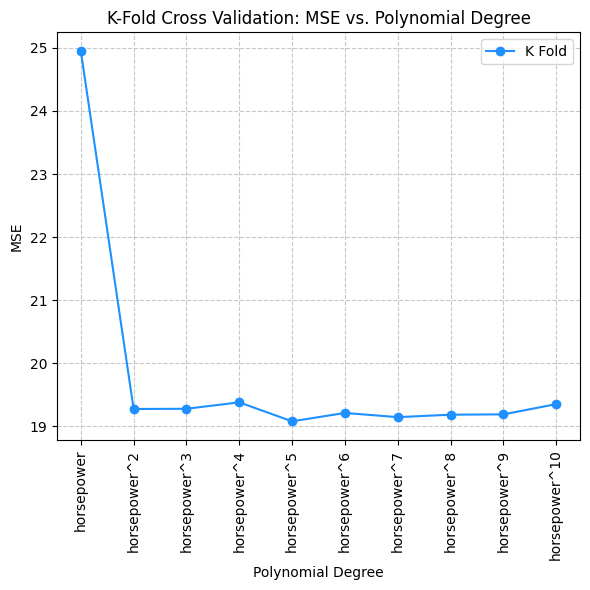

In [36]:
# Plot the results
plt.figure(figsize=figsize)
plt.plot(cv_results_KF.T, marker='o', label='K Fold', color=color_blue_light)
plt.xlabel('Polynomial Degree')
plt.xticks(ticks=range(len(cv_results_KF.columns)), labels=cv_results_KF.columns, rotation=90)
plt.ylabel('MSE')
plt.title('K-Fold Cross Validation: MSE vs. Polynomial Degree')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# 3. Leave One Out Cross Validation (LOOCV)

In [37]:
# Create the LOOCV cross-validator
cv = LeaveOneOut()

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    regr, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 18.897746795922835


In [38]:
# Initialize dictionary to store results
cv_results_LOOCV = {}

# Create the K-Fold cross-validator
cv = LeaveOneOut()

# Loop through each polynomial degree
for i in range(1, len(horsepower_cols)+1):
    # Perform cross-validation
    scores = cross_val_score(
        regr, X_train[horsepower_cols[:i]], y_train, 
        cv=cv, scoring=mse_scorer, n_jobs=-1
    )
    # Calculate the mean of the MSE scores (negate to get actual MSE)
    mean_mse = -scores.mean()

    # Store in results dictionary
    cv_results_LOOCV[horsepower_cols[i-1]] = mean_mse
    print(f'Mean CV MSE for {horsepower_cols[i-1]}: {mean_mse:.4f}')

# Convert results to DataFrame for plotting
cv_results_LOOCV = pd.DataFrame([cv_results_LOOCV])

Mean CV MSE for horsepower: 24.3641
Mean CV MSE for horsepower^2: 18.9238
Mean CV MSE for horsepower^3: 18.9490
Mean CV MSE for horsepower^4: 19.0824
Mean CV MSE for horsepower^5: 18.9175
Mean CV MSE for horsepower^6: 19.0483
Mean CV MSE for horsepower^7: 18.9730
Mean CV MSE for horsepower^8: 18.9452
Mean CV MSE for horsepower^9: 18.8507
Mean CV MSE for horsepower^10: 18.8977


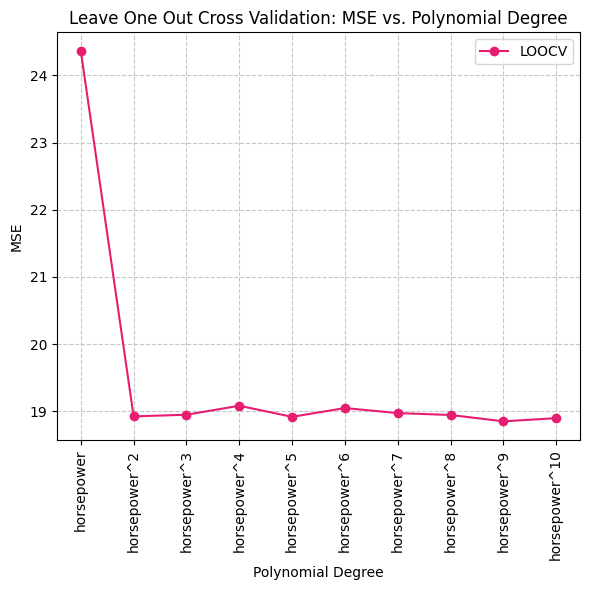

In [39]:
# Plot the results
plt.figure(figsize=figsize)
plt.plot(cv_results_LOOCV.T, marker='o', label='LOOCV', color=color_pink)
plt.xlabel('Polynomial Degree')
plt.xticks(ticks=range(len(cv_results_LOOCV.columns)), labels=cv_results_LOOCV.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Leave One Out Cross Validation: MSE vs. Polynomial Degree')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


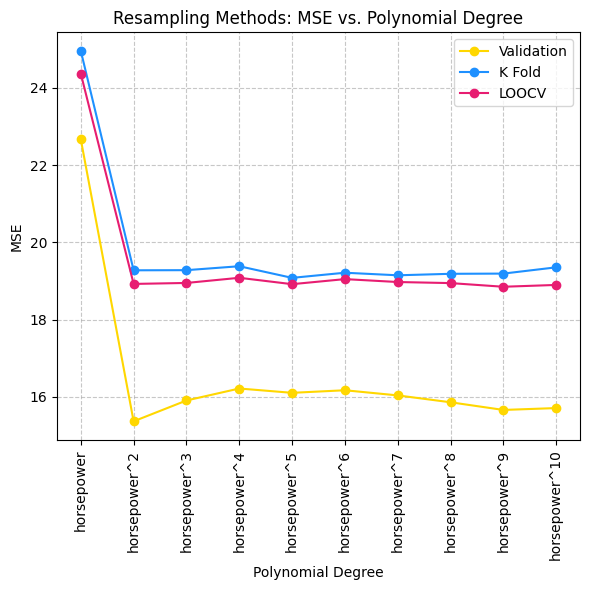

In [40]:
plt.figure(figsize=figsize)
plt.plot(results_val.T, marker='o', label='Validation', color=color_gold)
plt.plot(cv_results_KF.T, marker='o', label='K Fold', color=color_blue_light)
plt.plot(cv_results_LOOCV.T, marker='o', label='LOOCV', color=color_pink)
plt.xlabel('Polynomial Degree')
plt.xticks(ticks=range(len(cv_results_LOOCV.columns)), labels=cv_results_LOOCV.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Resampling Methods: MSE vs. Polynomial Degree')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
mse_test = {}

# Loop through each polynomial degree
for i in range(1, len(horsepower_cols)+1):
    # Train the model on the training set
    regr = regr.fit(X_train[horsepower_cols[:i]], y_train)
    y_pred = regr.predict(X_test[horsepower_cols[:i]])
    mse_test[horsepower_cols[i-1]] = mean_squared_error(y_test, y_pred)

# Convert results to DataFrame for plotting
mse_test = pd.DataFrame([mse_test])

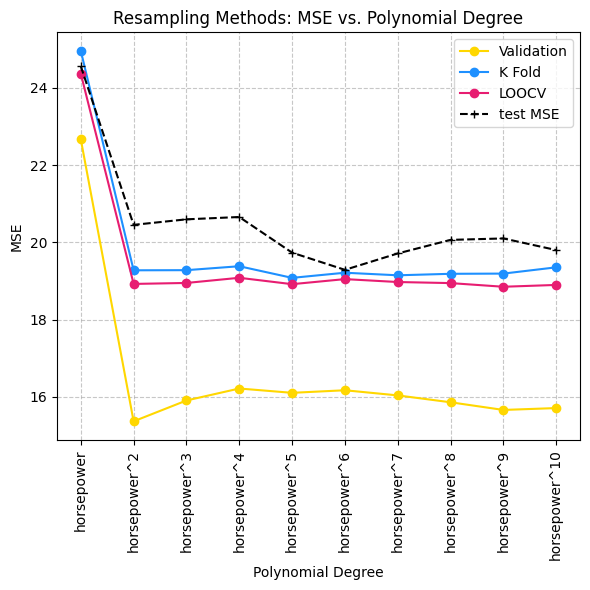

In [46]:
plt.figure(figsize=figsize)
plt.plot(results_val.T, marker='o', label='Validation', color=color_gold)
plt.plot(cv_results_KF.T, marker='o', label='K Fold', color=color_blue_light)
plt.plot(cv_results_LOOCV.T, marker='o', label='LOOCV', color=color_pink)
plt.plot(mse_test.T, marker='+', label='test MSE', linestyle='--' , color=color_black)

plt.xlabel('Polynomial Degree')
plt.xticks(ticks=range(len(cv_results_LOOCV.columns)), labels=cv_results_LOOCV.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Resampling Methods: MSE vs. Polynomial Degree')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()